# Simplex and Segmentation on GPU

This notebooks tests the GPU implementation of the Simplex operator against its numba-cpu version. 

Similarly, an example of segmentation is performed for both cases.

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import os
import warnings
warnings.filterwarnings('ignore')
import collections

import numpy as np
import cupy as cp
import scipy as sp
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import segyio

from scipy.signal import filtfilt
from scipy.linalg import solve
from scipy.sparse.linalg import lsqr
from scipy.ndimage import gaussian_filter
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.colors import Normalize

from pyproximal.proximal import *
from pyproximal import ProxOperator
from pyproximal.optimization.primal import *
from pyproximal.optimization.primaldual import *
from pyproximal.optimization.bregman import *
from pyproximal.optimization.segmentation import *

cp.cuda.Device(device=0).use();

## Create dataset

12 11


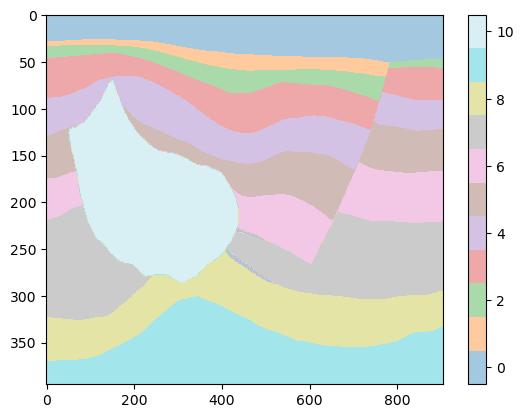

In [2]:
# Raw model
f = segyio.open('../data/seismicinversion/timodel_vp.segy', ignore_geometry=True)
vel = segyio.collect(f.trace[:]).T 

# Velocity model [m/s]
vel = np.pad(vel, ((80, 0), (0, 0)), constant_values=vel[0, 0])
vel = vel[::4, ::4] * 0.3048

# Density model [g/cc]
den = 2.

# Log impedance
m = np.log(vel * den)
m_max = m.max()
m_min = m.min()

# Model parameters
nt0, nx = m.shape
dt0 = 0.008
t0  = np.arange(nt0)*dt0
dx = 4
x = np.arange(nx)*dx

# extract classes
allcl = np.unique(m)
nclmin = 3000
cl = np.array(list(filter(lambda x: np.count_nonzero(m.ravel() == x) > nclmin, allcl)))
ncl = len(cl)
print(len(allcl), ncl)

# segmented model
vcl_true = np.zeros_like(m)

for icl in range(ncl):
    vcl_true[m == cl[icl]] = icl
    
plt.figure()
plt.imshow(vcl_true.reshape(nt0, nx),
           cmap=cm.get_cmap('tab20', ncl), 
           vmin=-0.5, vmax=ncl-0.5, alpha=0.4)
plt.axis('tight')
plt.colorbar();

In [3]:
Sop = Simplex(nt0 * nx * ncl, radius=1, dims=(ncl, nt0 * nx), axis=0,
              **dict(engine='numba', maxiter=10, call=False))

%timeit -n1 -r1 Sop.prox(np.ones(nt0 * nx * ncl), 1.)

13.7 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [4]:
Sop_cp = Simplex(nt0 * nx * ncl, radius=1, dims=(ncl, nt0 * nx), axis=0,
                 **dict(engine='cuda', maxiter=10, call=False))

%timeit -n1 -r1 Sop_cp.prox(np.ones(nt0 * nx * ncl), 1.)

644 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [5]:
Sop_cp = Simplex(nt0 * nx * ncl, radius=1, dims=(ncl, nt0 * nx), axis=0,
                 **dict(engine='cuda', maxiter=10, call=False))

%timeit -n1 -r1 Sop_cp.prox(cp.ones(nt0 * nx * ncl), 1.)

165 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [6]:
start = time.time()
segls, segls_classes = \
    Segment(m, cl, 20., 0.2, niter=5, show=True, 
            kwargs_simplex=dict(engine='numba', maxiter=10, call=False))
end = time.time()
print(end-start)

Primal-dual: min_x f(Ax) + x^T z + g(x)
---------------------------------------------------------
Proximal operator (f): <class 'pyproximal.proximal.Simplex._Simplex_numba'>
Proximal operator (g): <class 'pyproximal.proximal.VStack.VStack'>
Linear operator (A): <class 'pylops.basicoperators.blockdiag.BlockDiag'>
Additional vector (z): vector
tau = 1.0		mu = 0.125
theta = 1.00		niter = 5

   Itn       x[0]          f           g          z^x       J = f + g + z^x
     1   5.33203e-01   0.000e+00   8.226e+02   2.528e+04       2.610e+04
     2   5.62500e-01   0.000e+00   9.793e+02   1.202e+04       1.300e+04
     3   5.95703e-01   0.000e+00   1.057e+03   8.871e+03       9.929e+03
     4   6.28906e-01   0.000e+00   1.111e+03   7.831e+03       8.941e+03
     5   6.58203e-01   0.000e+00   1.166e+03   7.047e+03       8.212e+03

Total time (s) = 38.27
---------------------------------------------------------

38.30572152137756


In [7]:
start = time.time()
segls1, segls1_classes = \
    Segment(cp.asarray(m), cp.asarray(cl), 20., 0.2, niter=5, show=True, 
            kwargs_simplex=dict(engine='cuda', maxiter=10, call=False))
end = time.time()
print(end-start)

Primal-dual: min_x f(Ax) + x^T z + g(x)
---------------------------------------------------------
Proximal operator (f): <class 'pyproximal.proximal.Simplex._Simplex_cuda'>
Proximal operator (g): <class 'pyproximal.proximal.VStack.VStack'>
Linear operator (A): <class 'pylops.basicoperators.blockdiag.BlockDiag'>
Additional vector (z): vector
tau = 1.0		mu = 0.125
theta = 1.00		niter = 5

   Itn       x[0]          f           g          z^x       J = f + g + z^x
     1   5.33203e-01   0.000e+00   8.226e+02   2.528e+04       2.610e+04
     2   5.62500e-01   0.000e+00   9.793e+02   1.202e+04       1.300e+04
     3   5.95703e-01   0.000e+00   1.057e+03   8.871e+03       9.929e+03
     4   6.28906e-01   0.000e+00   1.111e+03   7.831e+03       8.941e+03
     5   6.58203e-01   0.000e+00   1.166e+03   7.047e+03       8.212e+03

Total time (s) = 0.14
---------------------------------------------------------

0.16408634185791016


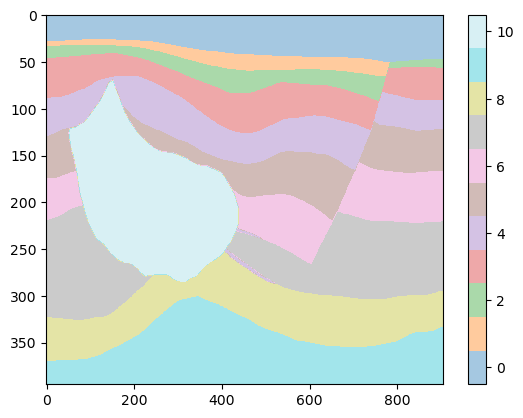

In [8]:
plt.figure()
plt.imshow(segls_classes.reshape(nt0, nx),
           cmap=cm.get_cmap('tab20', ncl), 
           vmin=-0.5, vmax=ncl-0.5, alpha=0.4)
plt.axis('tight')
plt.colorbar();

In [9]:
print(np.linalg.norm(cp.asnumpy(segls1)-segls)/np.linalg.norm(segls))
print(np.linalg.norm(cp.asnumpy(segls1_classes)-segls_classes)/np.linalg.norm(segls_classes))

1.2611478338216922e-08
0.0
